In [18]:
# Import local bentoml repository
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
import bentoml

print(bentoml.__file__)

/Users/bozhaoyu/src/bento/examples/pytorch-fashion-mnist/../../bentoml/__init__.py


# Convolutional autoencoder

source: https://github.com/baldassarreFe/zalando-pytorch

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

## Data

Load a custom subclass of torchvision.datasets.MNIST that instead downloads the FashionMNIST dataset 

(waiting for [this commit](https://github.com/pytorch/vision/commit/eec5ba4405c8815bd1797619d9cc9276f81b76f4) be available in the pip version of PyTorch).

In [20]:
from torchvision.datasets import MNIST

class FashionMNIST(MNIST):
    """`Fashion MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.
    """
    urls = [
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
    ]

    input_shape = (28, 28)
    num_classes = 10

    labels = [
        'T-shirt/top',
        'Trouser',
        'Pullover',
        'Dress',
        'Coat',
        'Sandal',
        'Shirt',
        'Sneaker',
        'Bag',
        'Ankle boot'
    ]

In [21]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

Load train and test set in batches of 1000.

The `28x28` images are scaled up to `29x29` so that combining convolutions and transposed convolutions would not chop off pixels from the reconstructed images.

In [22]:
batch_size = 1000

train_dataset = FashionMNIST(
    './data', train=True, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(
    './data', train=False, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Unsupervised reconstruction


In [23]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, stride=2)
        self.fully = nn.Linear(40, embedding_size)

    def forward(self, x):
        # 1x29x29
        x = F.relu(self.conv1(x))
        # 10x13x13
        x = F.relu(self.conv2(x))
        # 20x5x5
        x = F.relu(self.conv3(x))
        # 40x1x1
        x = x.view(x.data.shape[0], 40)
        # 40
        x = self.fully(x)
        # output_size
        return x

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.fully = nn.Linear(input_size, 40)
        self.conv1 = nn.ConvTranspose2d(40, 20, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(10, 1, kernel_size=5, stride=2)
    
    def forward(self, x):
        x = self.fully(x)
        x = x.view(x.data.shape[0], 40, 1, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.sigmoid(self.conv3(x))
        return x

In [24]:
embedding_size = 20
encoder = Encoder(embedding_size)
decoder = Decoder(embedding_size)

autoencoder = nn.Sequential(encoder, decoder)

## Supervised classification

In [25]:
for param in encoder.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    encoder, 
    nn.Linear(embedding_size, 15),
    nn.ReLU(),
    nn.Linear(15, len(FashionMNIST.labels)),
    nn.LogSoftmax()
)

### Training

In [26]:
classifier.train()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam([p for p in classifier.parameters() if p.requires_grad])
epoch_loss = []

for epoch in range(2):
    batch_loss = []
    for batch_num, (data, targets) in enumerate(train_loader):
        data, targets = Variable(data), Variable(targets)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.item() )
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    accuracy = accuracy_score(targets.data.numpy(), output.data.numpy().argmax(axis=1))
    print('Epoch {}:\tloss {:.4f}\taccuracy {:.2%}'.format(epoch, epoch_loss[-1], accuracy))

Epoch 0:	loss 2.3054	accuracy 9.50%
Epoch 1:	loss 2.3021	accuracy 20.50%


### Evaluation

In [27]:
classifier.eval()
data, targets = next(test_loader.__iter__())
outputs = classifier(Variable(data))
log_probs, output_classes = outputs.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 19.60%


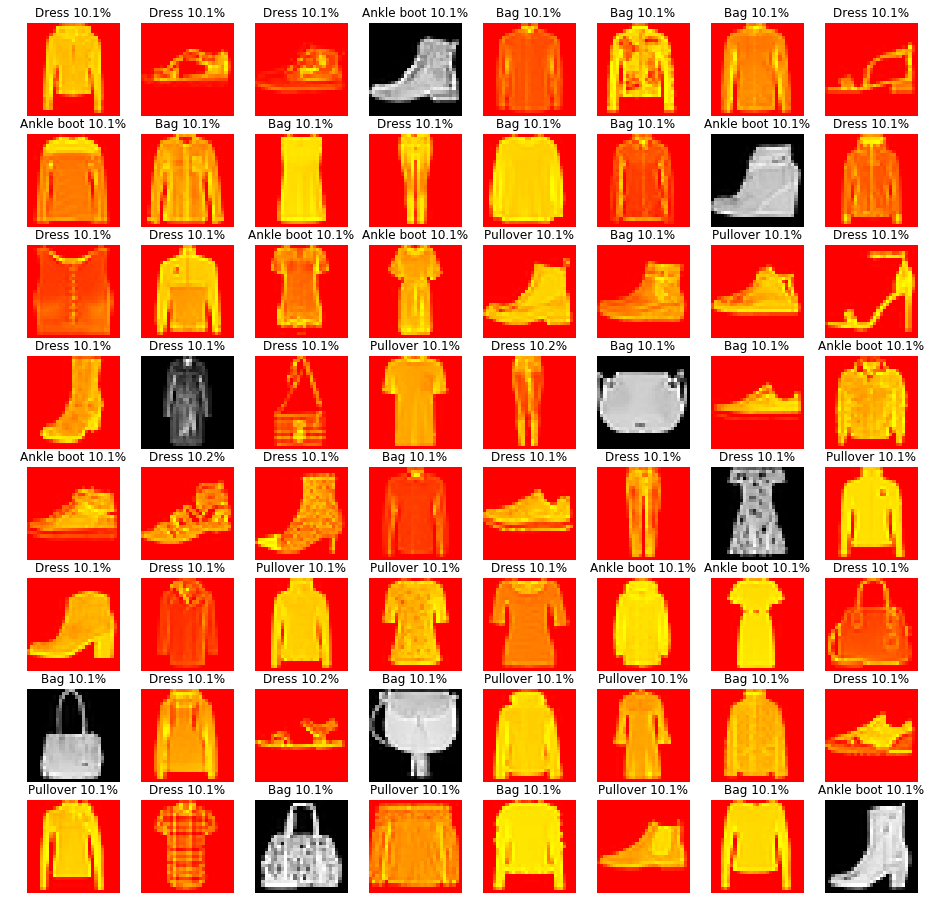

In [28]:
fig, axex = plt.subplots(8, 8, figsize=(16, 16))

zip_these = axex.ravel(), log_probs.data.exp(), output_classes.data, targets, data.numpy().squeeze()
for ax, prob, output_class, target, img in zip(*zip_these):
    ax.imshow(img, cmap='gray' if output_class == target else 'autumn')
    ax.axis('off')
    ax.set_title('{} {:.1%}'.format(FashionMNIST.labels[output_class], prob))

# Export model for production

In [29]:
%%writefile pytorch_fashion_mnist.py

import bentoml
from bentoml.artifact import PytorchModelArtifact
from bentoml.handlers import PytorchTensorHandler
from torch.autograd import Variable

@bentoml.env(conda_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('classifier')])
class FashionMNISTModel(bentoml.BentoService):
    """
    documentation strip
    """

    @bentoml.api(PytorchTensorHandler)
    def predict(self, tensor):
        output_tensor = self.artifacts.classifier(Variable(tensor))
        return output_tensor

Overwriting pytorch_fashion_mnist.py


In [30]:
from pytorch_fashion_mnist import FashionMNISTModel
new_model = FashionMNISTModel.pack(classifier=classifier)


saved_path = new_model.save('/tmp/bento')
print(saved_path)

/tmp/bento/FashionMNISTModel/b2019_04_10_4ef8747e


# Load model from archive

In [31]:
import bentoml

saved_model = bentoml.load(saved_path)
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)
testing_data, targets = next(data_loader.__iter__())

#call prediction
saved_model.predict(testing_data)

tensor([[-2.3024, -2.3340, -2.2910, -2.2963, -2.2979, -2.3058, -2.3116, -2.3020,
         -2.2920, -2.2936],
        [-2.3005, -2.3386, -2.2923, -2.2967, -2.2992, -2.3030, -2.3083, -2.3010,
         -2.2942, -2.2929],
        [-2.3040, -2.3376, -2.2947, -2.2925, -2.2974, -2.3012, -2.3109, -2.3013,
         -2.2935, -2.2936],
        [-2.3008, -2.3377, -2.2922, -2.2976, -2.2963, -2.3042, -2.3092, -2.3014,
         -2.2913, -2.2961],
        [-2.3044, -2.3358, -2.2987, -2.2899, -2.3005, -2.2982, -2.3121, -2.2973,
         -2.2956, -2.2943]], grad_fn=<LogSoftmaxBackward>)

##### * For demo purpurse, copy generated model to ./model folder

In [32]:
import os
import shutil
shutil.rmtree('./model', ignore_errors=True)
shutil.copytree(saved_path, './model')

'./model'

# Install exported model as a python package

In [38]:
!pip install ./model

Processing ./model
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-dzyt8cc6/wheels/ac/1a/f0/d32b0bea7601d5c58bc4370f4aef47c297de49d8f6addc23a3
Successfully built FashionMNISTModel
  Found existing installation: FashionMNISTModel 1.0.0
    Uninstalling FashionMNISTModel-1.0.0:
      Successfully uninstalled FashionMNISTModel-1.0.0


In [ ]:
# Your bentoML model class name will become packaged name
from FashionMNISTModel import FashionMNISTModel

ms = FashionMNISTModel()# call load to ensure all artifacts are loaded
ms.load()
result = ms.predict(testing_data)
log_probs, output_classes = result.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

# Build API server docker image

In [ ]:
!cd saved_path && docker build -t atalaya/sentiment-lr-model .